# Pipeline for AGEP column

Enable auto-reloading of external modules

In [197]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import dependencies

In [198]:
from matplotlib import rcParams
from sys import getsizeof
from pprint import pprint

from utils.data_loader import *
from utils.null_handler import *
from utils.EDA_utils import *
from utils.simple_utils import *
from utils.model_tuning_utils import *
from utils.stability_analysis import *
from utils.analysis_helper import *
from config import *

import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100

In [199]:
try:
    from folktables import ACSDataSource, ACSEmployment
except:
    !pip install folktables
    from folktables import ACSDataSource, ACSEmployment

## Loading ACSEmployment data

In [200]:
TARGET_COLUMN = 'AGEP'
COLUMN_TYPE = get_column_type(TARGET_COLUMN)

In [201]:
X_data_load, y_data = ACSDataLoader(task=DATASET_CONFIG['task'], state=DATASET_CONFIG['state'], year=DATASET_CONFIG['year'])

In [202]:
# If the task is ACSEmployment, we can optimize the file size
print(f'Original: {int(getsizeof(X_data_load) / 1024**2)} mb')
print(f'Optimized: {int(getsizeof(optimize_ACSEmployment(X_data_load)) / 1024**2)} mb')

X_data = optimize_ACSEmployment(X_data_load)

Original: 24 mb
Optimized: 12 mb


In [203]:
missing = ['SCHL', 'ESP', 'MIG', 'MIL', 'DREM']
X_data = initially_handle_nulls(X_data, missing)
# Rechecking if there are nulls -- if the null_handler has run correctly, there should not be
X_data.isnull().sum()

Dataset shape before handling nulls:  (196967, 16)
Impute values:  {'SCHL': 0, 'ESP': 0, 'MIG': 0, 'MIL': 0, 'DREM': 0}
Dataset shape after handling nulls:  (196967, 16)


AGEP        0
SCHL        0
MAR         0
RELP        0
DIS         0
ESP         0
CIT         0
MIG         0
MIL         0
ANC         0
NATIVITY    0
DEAR        0
DEYE        0
DREM        0
SEX         0
RAC1P       0
dtype: int64

## Tune hyper-parameters and find the best model

### The best model for a baseline dataset (no nulls)

In [204]:
ML_baseline_results_df = pd.read_csv(os.path.join('..', 'results', 'ML_baseline_results_df.csv'))
ML_baseline_results_df

,Unnamed: 0,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,0,Folktables [NY 2018],LogisticRegression,0.7998,0.7999,"{'max_iter': 100, 'penalty': 'l2', 'solver': '..."
1,1,Folktables [NY 2018],DecisionTreeClassifier,0.8229,0.8230,"{'criterion': 'entropy', 'max_depth': 10, 'max..."
2,2,Folktables [NY 2018],XGBClassifier,0.8296,0.8297,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


### Find the best model for a drop-column dataset (with nulls)

In [205]:
# # Copy datasets for tuning to avoid confusion with datasets for imputations
# baseline_X_data, baseline_y_data = X_data.copy(deep=True), y_data.copy(deep=True)
# baseline_X_data.drop(columns=[TARGET_COLUMN], axis=1, inplace=True)
# baseline_X_train_features, baseline_y_train, baseline_X_test_features, baseline_y_test = preprocess_dataset(X_data, y_data)
#
# ML_drop_column_results_df = test_models(baseline_X_train_features, baseline_y_train, baseline_X_test_features, baseline_y_test)
# ML_drop_column_results_df

In [206]:
# for index, row in ML_drop_column_results_df.iterrows():
#     print(f'\n\nModel name: {row["Model_Name"]}')
#     pprint(row['Model_Best_Params'])

## Simulate Null Scenarios

In [207]:
corrupted_data = simulate_scenario(X_data, SIMULATED_SCENARIOS_DICT[TARGET_COLUMN])

## Impute Nulls

Check correctness of conditional techniques

In [208]:
mapping_dict = check_conditional_techniques(corrupted_data, TARGET_COLUMN)
pprint(mapping_dict)

{'RAC1P': {'RAC1P-1': (2277, 'AGEP-60.0'),
           'RAC1P-2': (435, 'AGEP-19.0'),
           'RAC1P-3': (16, 'AGEP-17.0'),
           'RAC1P-4': (1, 'AGEP-27.0'),
           'RAC1P-5': (10, 'AGEP-52.0'),
           'RAC1P-6': (294, 'AGEP-45.0'),
           'RAC1P-7': (7, 'AGEP-29.0'),
           'RAC1P-8': (215, 'AGEP-18.0'),
           'RAC1P-9': (143, 'AGEP-1.0')},
 'SEX': {'SEX-1': (1482, 'AGEP-19.0'), 'SEX-2': (1630, 'AGEP-60.0')}}


Print plots for analysis

In [209]:
# TODO: enable plots after debugging
imputed_data_dict = impute_df_with_all_techniques(X_data, corrupted_data, TARGET_COLUMN, COLUMN_TYPE, enable_plots=False)





 ###############  Impute AGEP column with drop-column technique  ###############




 ###############  Impute AGEP column with drop-rows technique  ###############




 ###############  Impute AGEP column with predict-by-sklearn technique  ###############




 ###############  Impute AGEP column with impute-by-mean technique  ###############
Impute values:  {'AGEP': 42.0}




 ###############  Impute AGEP column with impute-by-mean-trimmed technique  ###############
Impute values:  {'AGEP': 42.0}




 ###############  Impute AGEP column with impute-by-mean-conditional technique  ###############
Impute AGEP with value 41.0, where SEX == 1
Impute AGEP with value 43.0, where SEX == 2
Impute AGEP with value 44.0, where RAC1P == 1
Impute AGEP with value 40.0, where RAC1P == 2
Impute AGEP with value 34.0, where RAC1P == 8
Impute AGEP with value 38.0, where RAC1P == 6
Impute AGEP with value 28.0, where RAC1P == 9
Impute AGEP with value 33.0, where RAC1P == 7
Impute AGEP with value 39.0, w

## Quantifying uncertainty using posterior predictive distribution

In [210]:
imputation_techniques = list(imputed_data_dict.keys())
imputation_techniques

['drop-column',
 'drop-rows',
 'predict-by-sklearn',
 'impute-by-mean',
 'impute-by-mean-trimmed',
 'impute-by-mean-conditional_SEX',
 'impute-by-mean-conditional_RAC1P',
 'impute-by-median',
 'impute-by-median-trimmed',
 'impute-by-median-conditional_SEX',
 'impute-by-median-conditional_RAC1P']

### Predict-by-sklearn technique

X_train_imputed.shape:  (118179, 74)
X_val_imputed.shape:  (39394, 74)
X_test_imputed.shape:  (39394, 74)


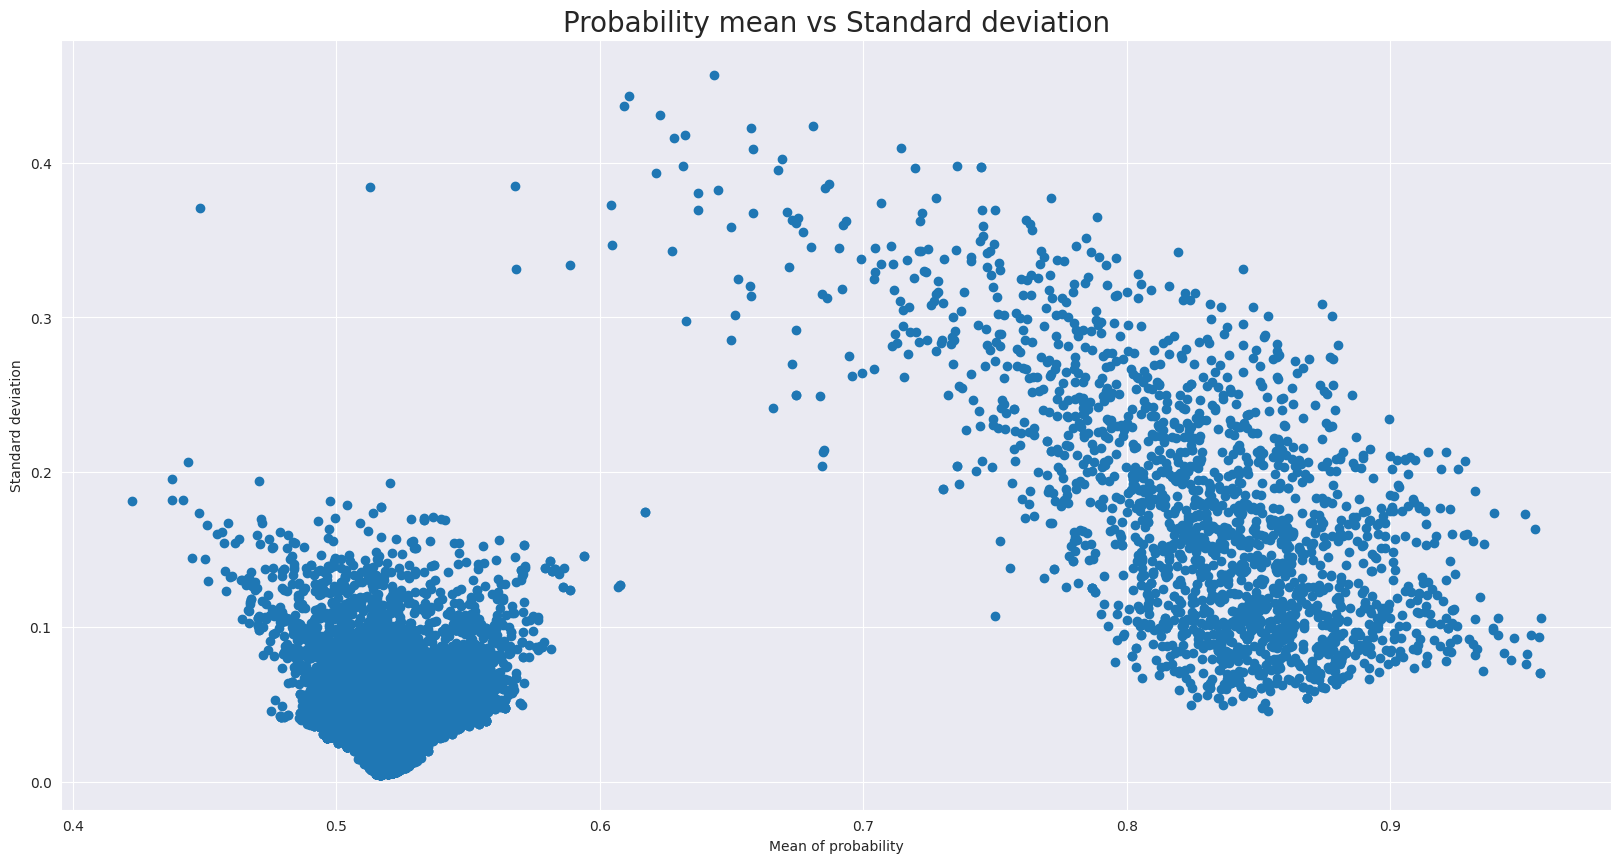

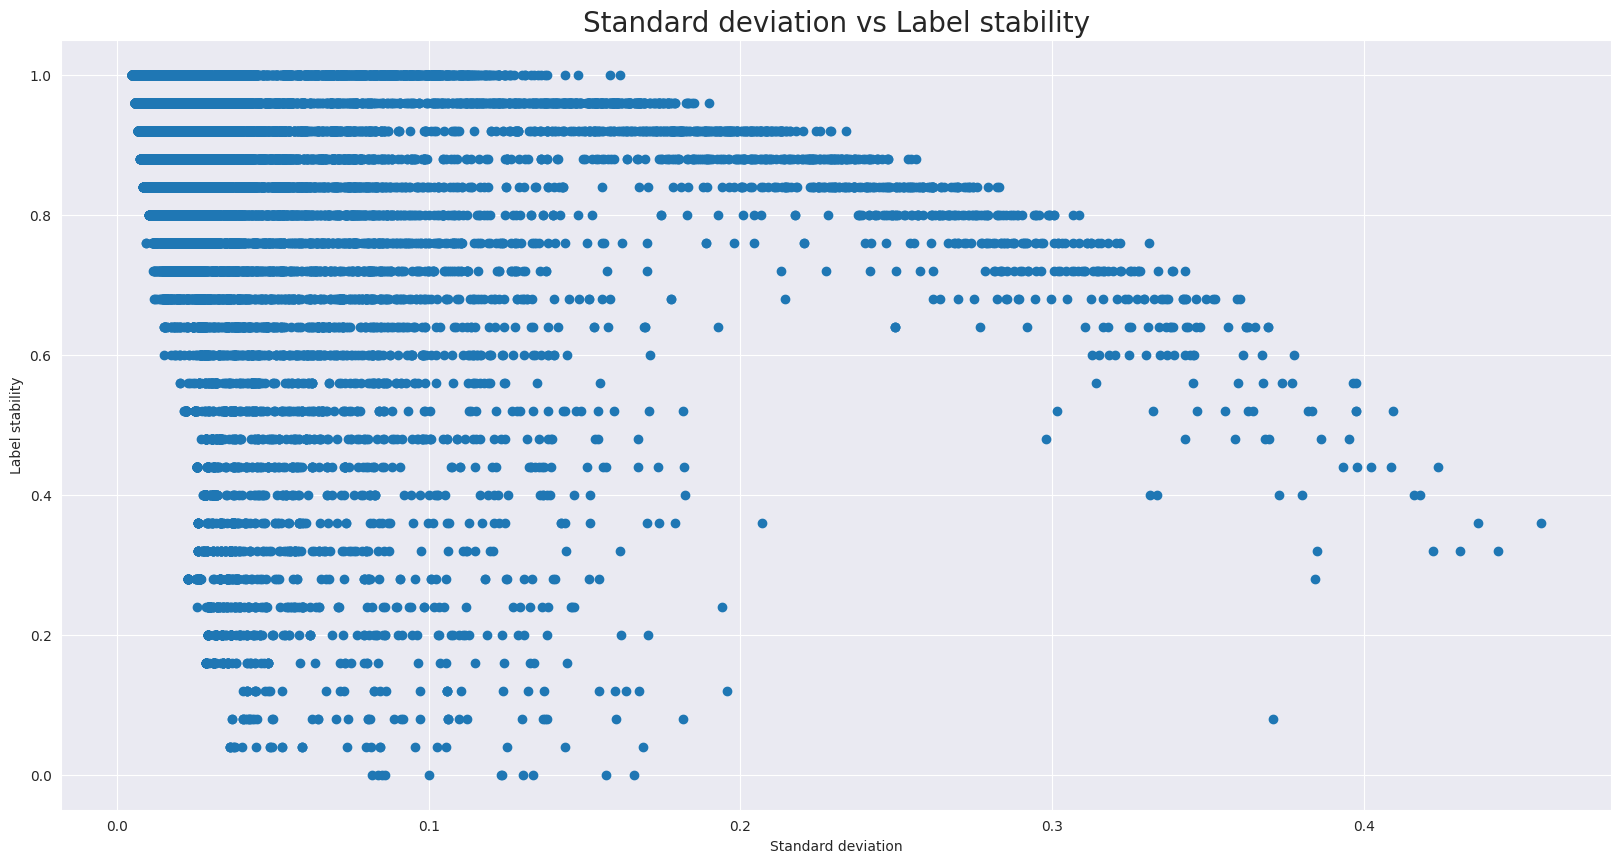

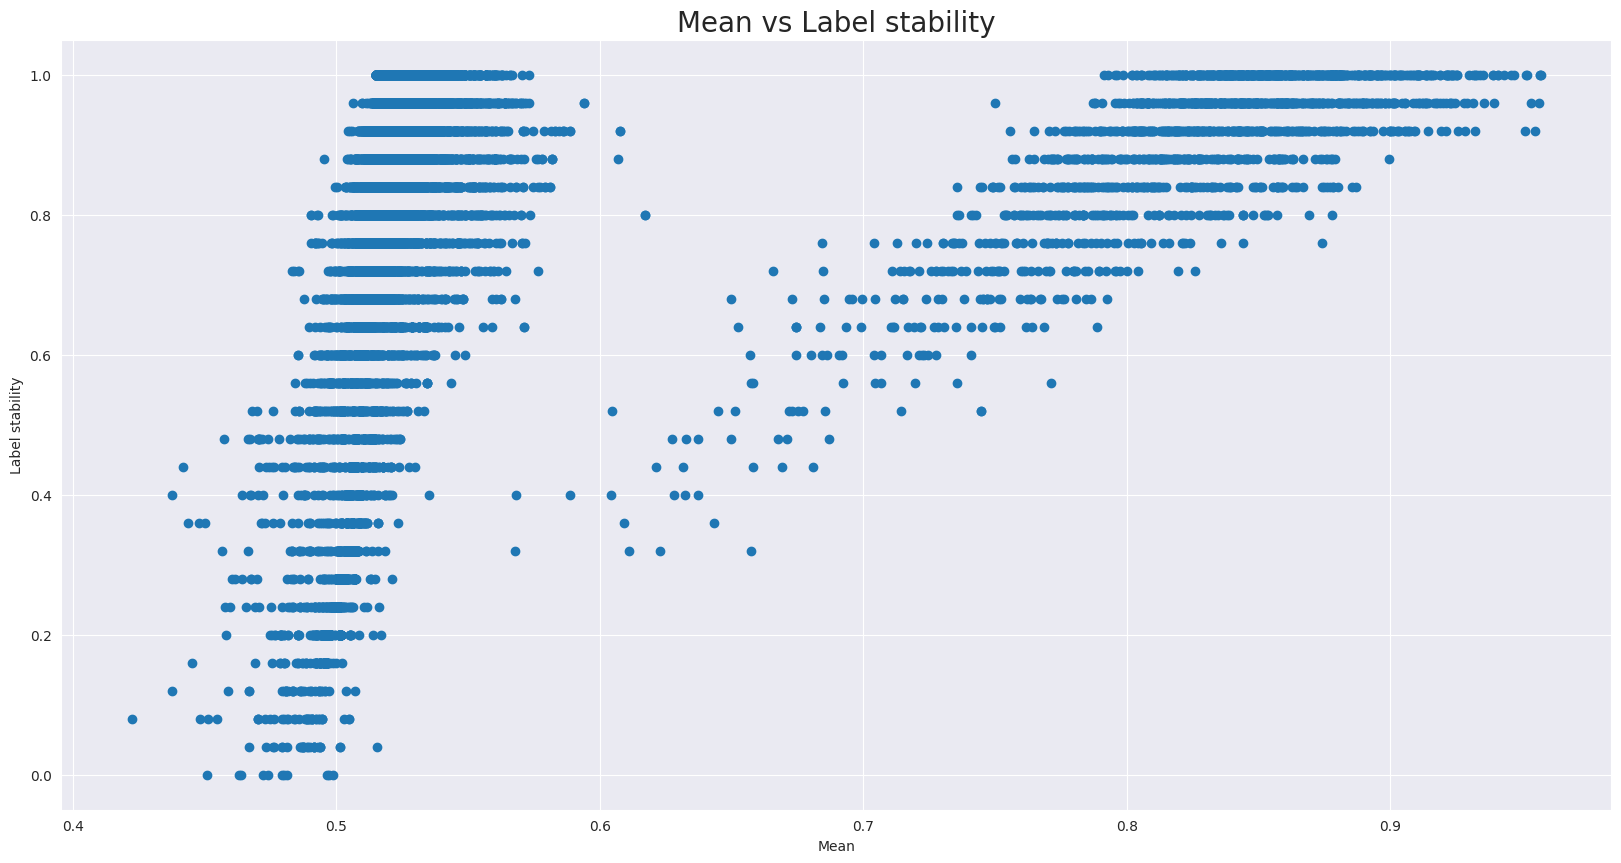

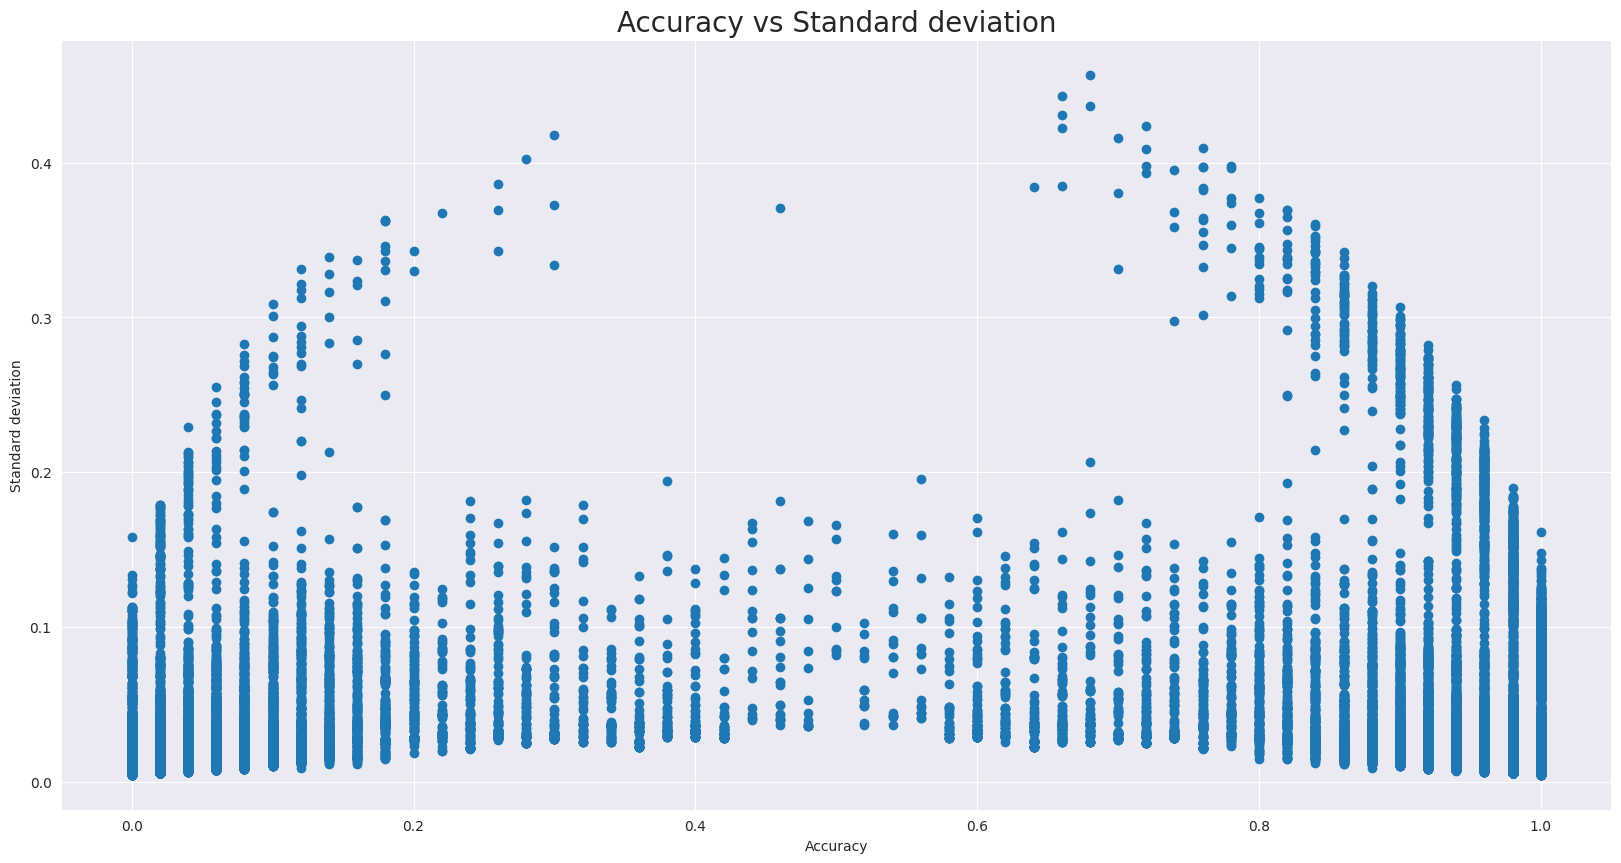

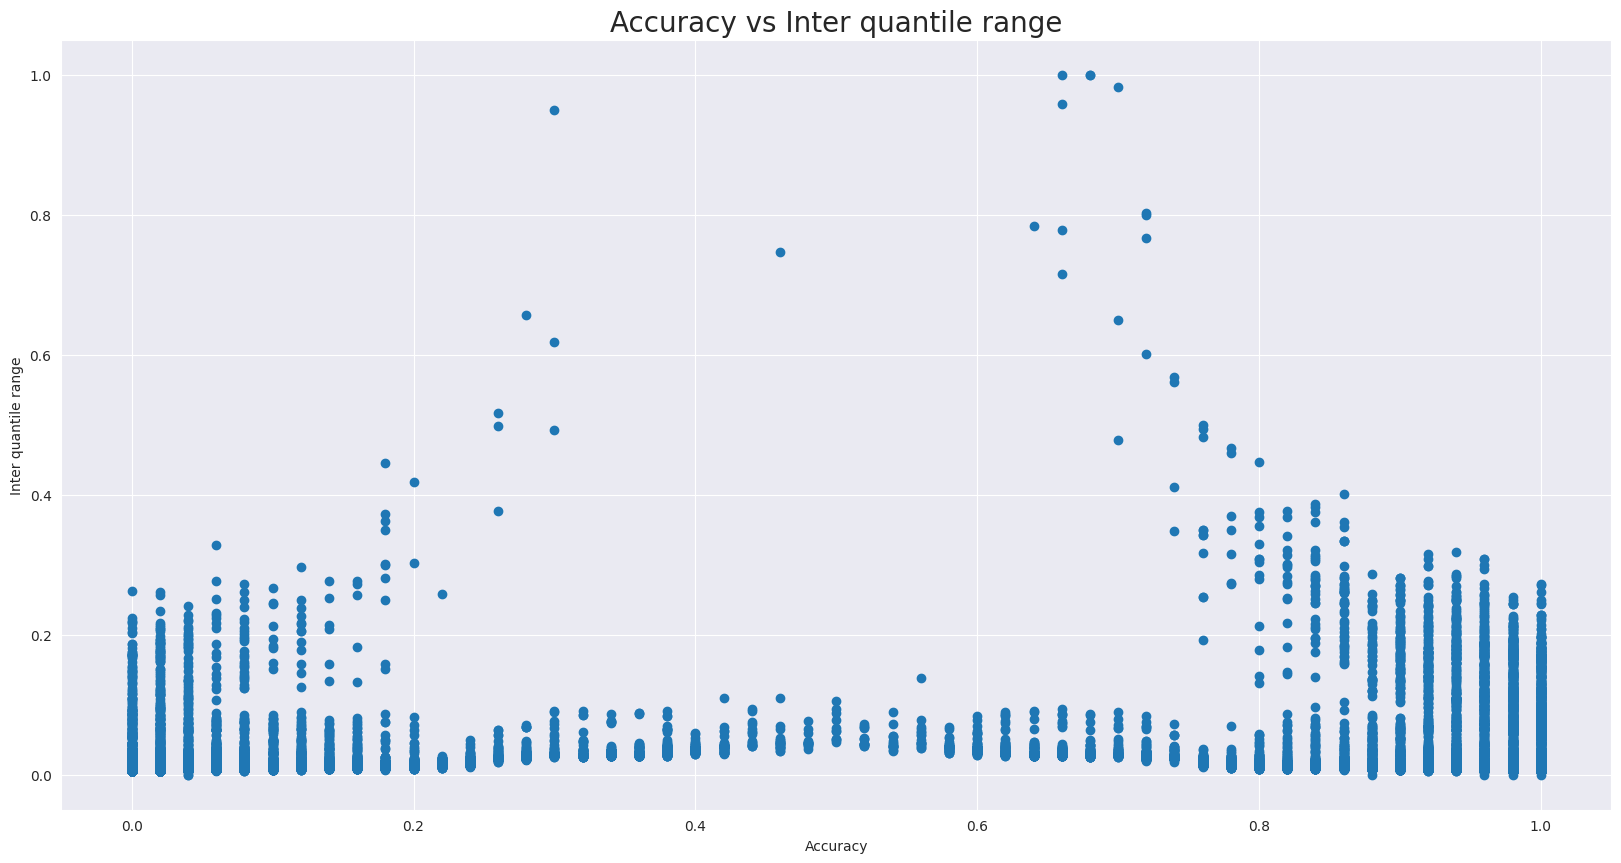

############################## Fairness metrics ##############################

#################### Accuracy ####################
              Race       Sex  Race_Sex
adv       0.532381  0.535039       NaN
disadv    0.543164  0.534434       NaN
Accuracy -0.010783  0.000605       NaN

#################### Disparate_Impact ####################
                      Race       Sex  Race_Sex
adv               0.017438  0.012555       NaN
disadv            0.012185  0.026574       NaN
Disparate_Impact  0.698744  2.116606       NaN

#################### Equal_Opportunity ####################
                       Race       Sex  Race_Sex
adv                0.018199  0.014215       NaN
disadv             0.010904  0.026391       NaN
Equal_Opportunity  0.007295 -0.012176       NaN

#################### Statistical_Parity_Difference ####################
                                   Race       Sex  Race_Sex
adv                            0.037327  0.026963       NaN
disadv             

In [211]:
quantify_uncertainty(TARGET_COLUMN, y_data, imputed_data_dict, imputation_technique='predict-by-sklearn')